In [9]:
import torch.nn as nn
import torch
from torchvision import models
from datasets.linemod.dataset import DepthDataset
import torch
import os
import torch.nn.functional as F
from lib.loss_depth import LogL2, L2
from torch import optim
import numpy as np
import time
import matplotlib.pyplot as plt
from lib.utils import setup_logger, im_convert, depth_to_img
from lib.network import DepthV2

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore") 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
dataset_root = "./datasets/linemod/Linemod_preprocessed"
log_dir = 'experiments/logs/depth_prediction'
outf = 'trained_models/depth_prediction'

dataset = DepthDataset('train', dataset_root)
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=1, 
                                         shuffle=True, 
                                         num_workers=1)

test_dataset = DepthDataset('test', dataset_root)
testdataloader = torch.utils.data.DataLoader(test_dataset, 
                                             batch_size=1, 
                                             shuffle=False, 
                                             num_workers=1)

Object 6 buffer loaded
Object 8 buffer loaded
Object 9 buffer loaded
Object 12 buffer loaded
Object 13 buffer loaded
Object 14 buffer loaded
Object 15 buffer loaded
Object 6 buffer loaded
Object 8 buffer loaded
Object 9 buffer loaded
Object 12 buffer loaded
Object 13 buffer loaded
Object 14 buffer loaded
Object 15 buffer loaded


In [11]:
estimator = DepthV2((480, 640))
estimator.cuda()
lr = 0.001
optimizer = optim.Adam(estimator.parameters(), lr=lr)

batch_size = 8
print_every = 32

lossLogL2 = LogL2()
lossL2 = L2()

# lr *= 0.3
# optimizer = optim.Adam(estimator.parameters(), lr=lr)

In [ ]:
start_epoch = 1
nepoch = 20
repeat_epoch = 1
best_test = np.Inf

if start_epoch == 1:
    for log in os.listdir(log_dir):
        if '.ipyn' not in log:
            os.remove(os.path.join(log_dir, log))
st_time = time.time()


for epoch in range(start_epoch, nepoch):
    mess = 'Train time {0}'.format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)) + ', ' + 'Training started')
    print(mess)
    
    train_count = 0
    loss_avg = 0.0
    
    estimator.train()
    optimizer.zero_grad()
    

    for i, data in enumerate(dataloader, 0):
        img, depth = data
        img, depth = img.float().cuda(), depth.float().cuda()
        pred_log_depth = estimator(img)

        loss = lossLogL2(pred_log_depth, depth)

        loss.backward()

        loss_avg += loss.item()
        train_count += 1

        if train_count % batch_size == 0:

            optimizer.step()
            optimizer.zero_grad()
            
 
            if train_count % print_every == 0:
                mess = 'Train time {0} Epoch {1} Batch {2} Frame {3} Avg_dis:{4}'.format(
                            time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)), 
                            epoch, int(train_count / batch_size), 
                            train_count, 
                            loss_avg / batch_size)
                print(mess)
                
            loss_avg = 0

        if train_count != 0 and train_count % 500 == 0:                    
            torch.save(estimator.state_dict(), '{0}/pose_model_current.pth'.format(outf))

    print('>>>>>>>>----------epoch {0} train finish---------<<<<<<<<'.format(epoch))
    
    test_loss = 0.0
    test_count = 0
    estimator.eval()
    
    for j, data in enumerate(testdataloader, 0):
        img, depth = data
        img, depth = img.float().cuda(), depth.float().cuda()
        
        pred_log_depth = estimator(img)
        
        loss = lossLogL2(pred_log_depth, depth)
        
        test_loss += loss.item()
        mess = 'Test time {0} Test Frame No.{1} dis:{2}'.format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)), test_count, loss)
        test_count += 1
        
    test_loss = test_loss / test_count
    mess = 'Test time {0} Epoch {1} TEST FINISH Avg dis: {2}'.format(time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - st_time)), epoch, test_loss)
    print(mess)
    
    if test_loss <= best_test:
        best_test = test_loss
        torch.save(estimator.state_dict(), '{0}/pose_model_{1}_{2}.pth'.format(outf, epoch, test_loss))
        print(epoch, '>>>>>>>>----------BEST TEST MODEL SAVED---------<<<<<<<<')
           
    if epoch % 2 == 0:
        lr *= 0.5
        optimizer = optim.Adam(estimator.parameters(), lr=lr)

In [13]:
test_iter = iter(testdataloader)

tensor(6.8325)


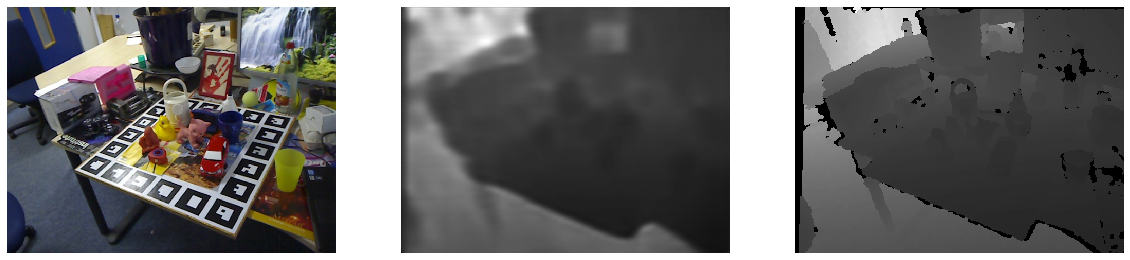

In [19]:
t = next(test_iter)
img, depth = t
img, depth = img.float().cuda(), depth.float().cuda()

model = 'trained_models/depth_prediction/pose_model_15_0.0002779090425557933.pth'
estimator = estimator = DepthV2((480, 640))
estimator.load_state_dict(torch.load(model))
estimator.cuda()
estimator.eval()

pred_log_depth = estimator(img).cpu().detach()[0]
pred_depth = torch.exp(pred_log_depth)

depth = depth.cpu()
max_d = torch.max(depth)
min_d = torch.min(depth)
depth_norm = (depth - min_d) * 255 / (max_d - min_d)

max_d = torch.max(pred_depth)
min_d = torch.min(pred_depth)
pred_depth_norm = (pred_depth - min_d) * 255 / (max_d - min_d)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.imshow(im_convert(img))
ax1.axis("off")
ax2.imshow(depth_to_img(pred_depth_norm), cmap='gray')
ax2.axis("off")
ax3.imshow(depth_to_img(depth_norm), cmap='gray')
ax3.axis("off")

print(lossL2(pred_log_depth, depth))

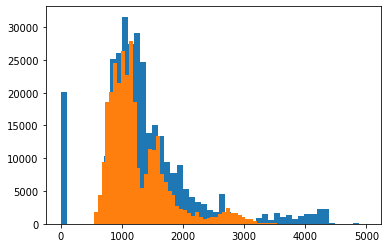

In [20]:
a = depth.cpu().detach().numpy().reshape(-1, 1)
plt.hist(a, bins=50);
b = pred_depth.cpu().detach().numpy().reshape(-1, 1)
plt.hist(b, bins=50);

In [39]:
depth

tensor([[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.,  ..., 667.,   0.,   0.],
         [  0.,   0.,   0.,  ..., 667.,   0.,   0.],
         [  0.,   0.,   0.,  ..., 666., 666.,   0.]]])

In [44]:
mask_depth = depth.eq(0.)

In [46]:
depth[mask_depth] = 1

In [52]:
def im_grad(img):
    fx = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]]).view(1, 1, 3, 3).float().cuda()
    fx_conv = nn.Conv2d(1, 1, kernel_size=3, bias=False, padding=1)
    fx_conv.weight = nn.Parameter(fx)

    fy = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]).view(1, 1, 3, 3).float().cuda()
    fy_conv = nn.Conv2d(1, 1, kernel_size=3, bias=False, padding=1)
    fy_conv.weight = nn.Parameter(fy)

    img_mean = torch.mean(img, 1, True)
    grad_x = fx_conv(img_mean)
    grad_y = fy_conv(img_mean)
    
    return grad_x, grad_y

In [53]:
grad_x, grad_y = im_grad(img)

In [59]:
grad_x[:, :, None, :].shape

torch.Size([1, 1, 1, 480, 640])

In [60]:
grad_x[:, :, :, None].shape

torch.Size([1, 1, 480, 1, 640])